## Imports

In [1]:
import glob
import os
import numpy as np
import re
import pickle

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
import stanza

from stanza.server import CoreNLPClient

In [15]:
from tqdm import tqdm

In [16]:
import cv2
from PIL import Image
import pyvips

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.io.image import ImageReadMode

## Experiments

### Generating df experiments

In [4]:
ls /MIMIC_CXR_JPG/files/

index.html  p10/  p11/  p12/  p13/  p14/  p15/  p16/  p17/  p18/  p19/


In [5]:
patient_folders = []
for i in range(10,20):
    patient_folders.extend(glob.glob(f'/MIMIC_CXR_JPG/files/p{i}/p{i}*/'))

In [12]:
len(patient_folders)

65379

In [15]:
image_files = []
for pf in tqdm(patient_folders):
    image_files.extend(glob.glob(f'{pf}/s*/*.jpg'))

  0%|          | 0/65379 [00:00<?, ?it/s]

In [17]:
len(image_files)

377110

In [ ]:
text_reports = []

In [18]:
ls {patient_folders[0]}

index.html  s50414267.txt  s53189527.txt  s53911762.txt  s56699142.txt
s50414267/  s53189527/     s53911762/     s56699142/


In [21]:
cat {patient_folders[0] + 's50414267.txt'}

                                 FINAL REPORT
 EXAMINATION:  CHEST (PA AND LAT)
 
 INDICATION:  ___F with new onset ascites  // eval for infection
 
 TECHNIQUE:  Chest PA and lateral
 
 COMPARISON:  None.
 
 FINDINGS: 
 
 There is no focal consolidation, pleural effusion or pneumothorax.  Bilateral
 nodular opacities that most likely represent nipple shadows. The
 cardiomediastinal silhouette is normal.  Clips project over the left lung,
 potentially within the breast. The imaged upper abdomen is unremarkable.
 Chronic deformity of the posterior left sixth and seventh ribs are noted.
 
 IMPRESSION: 
 
 No acute cardiopulmonary process.

In [4]:
study_ids_folders = glob.glob('/MIMIC_CXR_JPG/files/p*/p*/s*/')

In [5]:
text_reports_df = pd.DataFrame(np.vstack(pd.Series(study_ids_folders).apply(lambda x: x.split('/')[3:6]).values), columns=['patient_folder', 'patient_id', 'study_id'])

In [6]:
text_reports_df.head()

,patient_folder,patient_id,study_id
0,p10,p10000032,s50414267
1,p10,p10000032,s53189527
2,p10,p10000032,s53911762
3,p10,p10000032,s56699142
4,p10,p10000764,s57375967


In [7]:
text_reports_df.shape

(227835, 3)

In [8]:
def get_findings_impressions(r):
    findings, impression = '', ''
    with open(f'/MIMIC_CXR_JPG/files/{r["patient_folder"]}/{r["patient_id"]}/{r["study_id"]}.txt') as f:
        data = f.read()
        # Check for both FINDINGS and impression
        matches = re.search(r"^([\w\W]+?)\bFINDINGS\b([\w\W]+?)\bIMPRESSION\b([\w\W]+?)$", data)
        if matches and len(matches.groups())==3:
            findings = matches.group(2)
            impression = matches.group(3)
        if len(findings)==0:
            findings_match = re.search(r"^([\w\W]+?)\bFINDINGS\b([\w\W]+?)$", data)
            if findings_match and len(findings_match.groups())==2:
                findings = findings_match.group(2)
        if len(impression)==0:
            impression_match = re.search(r"^([\w\W]+?)\bIMPRESSION\b([\w\W]+?)$", data)
            #print(len(impression_match.groups()))
            if impression_match and len(impression_match.groups())==2:
                impression = impression_match.group(2)
        
    return findings, impression

In [9]:
find_impres_series = text_reports_df.apply(lambda x: get_findings_impressions(x), axis=1)

In [10]:
text_reports_df['findings'] = find_impres_series.apply(lambda x: x[0])
text_reports_df['impressions'] = find_impres_series.apply(lambda x: x[1])

In [11]:
problem_df = text_reports_df[text_reports_df.apply(lambda x: not (x['findings']!='' or x['impressions']!=''), axis=1)]
problem_df.shape

(11514, 5)

In [21]:
r = problem_df.iloc[1]

In [25]:
for _, r in problem_df.sample(10).iterrows():
    with open(f'/MIMIC_CXR_JPG/files/{r["patient_folder"]}/{r["patient_id"]}/{r["study_id"]}.txt') as f:
        data = f.read()

    print(data)
    
    print("-"*100)

                                 FINAL REPORT
 SINGLE FRONTAL VIEW OF THE CHEST
 
 REASON FOR EXAM:  Tracheoplasty for tracheobronchomalacia, failed extubation. 
 Comparison is made with prior study ___.
 
 Tracheostomy tube is in standard position.  NG tube tip is out of view below
 the diaphragm.  There are low lung volumes.  Cardiomegaly and widened
 mediastinum are unchanged.  There is no evident pneumothorax .  Right upper
 lobe opacity has improved.  Bibasilar opacities, larger on the left side are
 unchanged.  If any, there is a small right pleural effusion.
----------------------------------------------------------------------------------------------------
                                 FINAL REPORT
 SINGLE PORTABLE VIEW OF THE CHEST
 
 REASON FOR EXAM:  Intubated patient with respiratory failure.
 
 Comparison is made with prior study performed the same day earlier in the
 morning.
 
 There are persistent low lung volumes.  There is mild cardiomegaly. 
 Mild-to-moderate pulm

In [12]:
text_reports_df = text_reports_df[text_reports_df.apply(lambda x: len(x['findings'])!=0 or len(x['impressions'])!=0, axis=1)]

In [13]:
text_reports_df['findings'].apply(len).value_counts()[0],text_reports_df['impressions'].apply(len).value_counts()[0], text_reports_df['findings'].apply(len).value_counts()[0]+text_reports_df['impressions'].apply(len).value_counts()[0]

(66297, 28506, 94803)

In [14]:
text_reports_df.apply(lambda x: len(x['findings'])==0 or len(x['impressions'])==0, axis=1).value_counts()

False    121518
True      94803
dtype: int64

In [16]:
x = text_reports_df.iloc[0]['findings']
x

': \n \n There is no focal consolidation, pleural effusion or pneumothorax.  Bilateral\n nodular opacities that most likely represent nipple shadows. The\n cardiomediastinal silhouette is normal.  Clips project over the left lung,\n potentially within the breast. The imaged upper abdomen is unremarkable.\n Chronic deformity of the posterior left sixth and seventh ribs are noted.\n \n '

In [17]:
with CoreNLPClient(properties={
      'annotators': 'tokenize'
  }) as client:
    t = client.annotate(x)

2022-12-03 14:57:58 INFO: Writing properties to tmp file: corenlp_server-d1ced69fbd9a4585.props
2022-12-03 14:57:58 INFO: Starting server with command: java -Xmx5G -cp /scratch/tm3647/stanza_corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet False -serverProperties corenlp_server-d1ced69fbd9a4585.props -preload -outputFormat serialized
[main] INFO CoreNLP - --- StanfordCoreNLPServer#main() called ---
[main] INFO CoreNLP - Server default properties:
			(Note: unspecified annotator properties are English defaults)
			annotators = tokenize
			inputFormat = text
			outputFormat = serialized
			prettyPrint = false
			threads = 5
[main] INFO CoreNLP - Threads: 5
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO CoreNLP - Starting server...
[main] INFO CoreNLP - StanfordCoreNLPServer listening at /0:0:0:0:0:0:0:0:9000
[pool-1-thread-3] INFO CoreNLP - [/127.0.0.1:58622] API call

:     There is no focal consolidation, pleural effusion or pneumothorax.  Bilateral  nodular opacities that most likely represent nipple shadows. The  cardiomediastinal silhouette is normal.  Clips project over the left lung,  potentially within the breast. The imaged upper abdomen is unremarkable.  Chronic deformity of the posterior left sixth and seventh ribs are noted.    


[Thread-0] INFO CoreNLP - CoreNLP Server is shutting down.


In [35]:
def get_sentences(tokenized_sentences):
    final_sentences = []
    for sent in tokenized_sentences:
        if len(sent.token)>3:
            ## Convert tokens to a string and replace the intermediate new lines
            final_sent = ''.join(list(map(lambda x: x.before.replace('\n', '')+x.word, list(sent.token)))).strip()
            if final_sent.startswith(":"):
                final_sent = final_sent.replace(":", "").strip()
            final_sentences.append(final_sent)
    
    return final_sentences

In [36]:
get_sentences(t.sentence)

['There is no focal consolidation, pleural effusion or pneumothorax.',
 'Bilateral nodular opacities that most likely represent nipple shadows.',
 'The cardiomediastinal silhouette is normal.',
 'Clips project over the left lung, potentially within the breast.',
 'The imaged upper abdomen is unremarkable.',
 'Chronic deformity of the posterior left sixth and seventh ribs are noted.']

In [41]:
text_reports_df['findings_tokenized_sentences'] = None
text_reports_df['impressions_tokenized_sentences'] = None

In [43]:
r

patient_folder                                                                   p10
patient_id                                                                 p10000032
study_id                                                                   s50414267
findings                           : \n \n There is no focal consolidation, pleur...
impressions                                : \n \n No acute cardiopulmonary process.
findings_tokenized_sentences       [There is no focal consolidation, pleural effu...
impressions_tokenized_sentences                                                 None
Name: 0, dtype: object

In [46]:
with CoreNLPClient(properties={
      'annotators': 'tokenize'
  }, be_quiet=True) as client:
    for i, (idx, r) in tqdm(enumerate(text_reports_df.iterrows()), total=text_reports_df.shape[0]):
        cnlp_out = client.annotate(r['findings'])
        text_reports_df.loc[idx, 'findings_tokenized_sentences'] = get_sentences(cnlp_out.sentence)
        cnlp_out = client.annotate(r['impressions'])
        text_reports_df.loc[idx, 'impressions_tokenized_sentences'] = get_sentences(cnlp_out.sentence)
        if (i%100==0):
            print(i)

2022-12-03 15:35:38 INFO: Writing properties to tmp file: corenlp_server-fdb2dc0ba28f4426.props
2022-12-03 15:35:38 INFO: Starting server with command: java -Xmx5G -cp /scratch/tm3647/stanza_corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-fdb2dc0ba28f4426.props -preload -outputFormat serialized


  0%|          | 0/216321 [00:00<?, ?it/s]

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

133000
133100
133200
133300
133400
133500
133600
133700
133800
133900
134000
134100
134200
134300
134400
134500
134600
134700
134800
134900
135000
135100
135200
135300
135400
135500
135600
135700
135800
135900
136000
136100
136200
136300
136400
136500
136600
136700
136800
136900
137000
137100
137200
137300
137400
137500
137600
137700
137800
137900
138000
138100
138200
138300
138400
138500
138600
138700
138800
138900
139000
139100
139200
139300
139400
139500
139600
139700
139800
139900
140000
140100
140200
140300
140400
140500
140600
140700
140800
140900
141000
141100
141200
141300
141400
141500
141600
141700
141800
141900
142000
142100
142200
142300
142400
142500
142600
142700
142800
142900
143000
143100
143200
143300
143400
143500
143600
143700
143800
143900
144000
144100
144200
144300
144400
144500
144600
144700
144800
144900
145000
145100
145200
145300
145400
145500
145600
145700
145800
145900
146000
146100
146200
146300
146400
146500
146600
146700
146800
146900
147000
147100
147200

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [47]:
text_reports_df

,patient_folder,patient_id,study_id,findings,impressions,findings_tokenized_sentences,impressions_tokenized_sentences
0,p10,p10000032,s50414267,": \n \n There is no focal consolidation, pleur...",: \n \n No acute cardiopulmonary process.,"[There is no focal consolidation, pleural effu...",[No acute cardiopulmonary process.]
1,p10,p10000032,s53189527,": \n \n The cardiac, mediastinal and hilar con...",: \n \n No acute cardiopulmonary abnormality.,"[The cardiac, mediastinal and hilar contours a...",[No acute cardiopulmonary abnormality.]
2,p10,p10000032,s53911762,: \n \n Single frontal view of the chest provi...,: \n \n No acute intrathoracic process.,"[Single frontal view of the chest provided., T...",[No acute intrathoracic process.]
3,p10,p10000032,s56699142,: \n \n The lungs are clear of focal consolida...,: \n \n No acute cardiopulmonary process.,"[The lungs are clear of focal consolidation, p...",[No acute cardiopulmonary process.]
4,p10,p10000764,s57375967,: \n \n PA and lateral views of the chest prov...,: \n \n Focal consolidation at the left lung b...,"[PA and lateral views of the chest provided., ...","[Focal consolidation at the left lung base, po..."
...,...,...,...,...,...,...,...
227830,p19,p19999442,s58708861,:\n \n ET tube ends 4.7 cm above the carina. ...,,"[ET tube ends 4.7 cm above the carina., NG tub...",[]
227831,p19,p19999733,s57132437,": The lungs are clear, and the cardiomediasti...",: No acute cardiothoracic process.,"[The lungs are clear, and the cardiomediastina...",[No acute cardiothoracic process.]
227832,p19,p19999987,s55368167,: There has been interval extubation and impr...,,[There has been interval extubation and improv...,[]
227833,p19,p19999987,s58621812,: Portable supine AP view of the chest provid...,: Appropriately positioned ET and NG tubes. ...,[Portable supine AP view of the chest provided...,[Appropriately positioned ET and NG tubes.]


In [49]:
with open('/scratch/tm3647/public/mimic_text_reports_df.pkl', 'wb') as f:
    pickle.dump(text_reports_df, f)

In [68]:
text_reports_df.apply(lambda x: glob.glob(f'/MIMIC_CXR_JPG/files/{x["patient_folder"]}/{x["patient_id"]}/{x["study_id"]}/*.jpg'), axis=1).apply(len).value_counts()

2     99900
1     95370
3     18875
4      2040
5        98
6        31
8         3
7         2
9         1
11        1
dtype: int64

In [69]:
text_reports_df['image_files'] = text_reports_df.apply(lambda x: glob.glob(f'/MIMIC_CXR_JPG/files/{x["patient_folder"]}/{x["patient_id"]}/{x["study_id"]}/*.jpg'), axis=1)

In [84]:
final_image_text_df = text_reports_df.explode("image_files").reset_index(drop=True)

In [117]:
final_image_text_df.rename(columns={'image_files':'image_fname'}, inplace=True)

In [118]:
final_image_text_df.head()

,patient_folder,patient_id,study_id,findings,impressions,findings_tokenized_sentences,impressions_tokenized_sentences,image_fname
0,p10,p10000032,s50414267,": \n \n There is no focal consolidation, pleur...",: \n \n No acute cardiopulmonary process.,"[There is no focal consolidation, pleural effu...",[No acute cardiopulmonary process.],/MIMIC_CXR_JPG/files/p10/p10000032/s50414267/0...
1,p10,p10000032,s50414267,": \n \n There is no focal consolidation, pleur...",: \n \n No acute cardiopulmonary process.,"[There is no focal consolidation, pleural effu...",[No acute cardiopulmonary process.],/MIMIC_CXR_JPG/files/p10/p10000032/s50414267/1...
2,p10,p10000032,s53189527,": \n \n The cardiac, mediastinal and hilar con...",: \n \n No acute cardiopulmonary abnormality.,"[The cardiac, mediastinal and hilar contours a...",[No acute cardiopulmonary abnormality.],/MIMIC_CXR_JPG/files/p10/p10000032/s53189527/2...
3,p10,p10000032,s53189527,": \n \n The cardiac, mediastinal and hilar con...",: \n \n No acute cardiopulmonary abnormality.,"[The cardiac, mediastinal and hilar contours a...",[No acute cardiopulmonary abnormality.],/MIMIC_CXR_JPG/files/p10/p10000032/s53189527/e...
4,p10,p10000032,s53911762,: \n \n Single frontal view of the chest provi...,: \n \n No acute intrathoracic process.,"[Single frontal view of the chest provided., T...",[No acute intrathoracic process.],/MIMIC_CXR_JPG/files/p10/p10000032/s53911762/6...


In [119]:
with open('/scratch/tm3647/public/mimic_image_text_df.pkl', 'wb') as f:
    pickle.dump(final_image_text_df, f)

### Reload Dataframe

In [4]:
with open('/scratch/tm3647/public/mimic_image_text_df.pkl', 'rb') as f:
    final_image_text_df = pickle.load(f)

In [19]:
final_image_text_df.head()

,patient_folder,patient_id,study_id,findings,impressions,findings_tokenized_sentences,impressions_tokenized_sentences,orig_image_fname,image_fname
0,p10,p10000032,s50414267,": \n \n There is no focal consolidation, pleur...",: \n \n No acute cardiopulmonary process.,"[There is no focal consolidation, pleural effu...",[No acute cardiopulmonary process.],/MIMIC_CXR_JPG/files/p10/p10000032/s50414267/0...,/MIMIC_CXR_JPG/files/p10/p10000032/s50414267/0...
1,p10,p10000032,s50414267,": \n \n There is no focal consolidation, pleur...",: \n \n No acute cardiopulmonary process.,"[There is no focal consolidation, pleural effu...",[No acute cardiopulmonary process.],/MIMIC_CXR_JPG/files/p10/p10000032/s50414267/1...,/MIMIC_CXR_JPG/files/p10/p10000032/s50414267/1...
2,p10,p10000032,s53189527,": \n \n The cardiac, mediastinal and hilar con...",: \n \n No acute cardiopulmonary abnormality.,"[The cardiac, mediastinal and hilar contours a...",[No acute cardiopulmonary abnormality.],/MIMIC_CXR_JPG/files/p10/p10000032/s53189527/2...,/MIMIC_CXR_JPG/files/p10/p10000032/s53189527/2...
3,p10,p10000032,s53189527,": \n \n The cardiac, mediastinal and hilar con...",: \n \n No acute cardiopulmonary abnormality.,"[The cardiac, mediastinal and hilar contours a...",[No acute cardiopulmonary abnormality.],/MIMIC_CXR_JPG/files/p10/p10000032/s53189527/e...,/MIMIC_CXR_JPG/files/p10/p10000032/s53189527/e...
4,p10,p10000032,s53911762,: \n \n Single frontal view of the chest provi...,: \n \n No acute intrathoracic process.,"[Single frontal view of the chest provided., T...",[No acute intrathoracic process.],/MIMIC_CXR_JPG/files/p10/p10000032/s53911762/6...,/MIMIC_CXR_JPG/files/p10/p10000032/s53911762/6...


#### Resize images and store on the disk (later created squash out of this)

In [20]:
final_image_text_df['resized_image_fname'] = final_image_text_df['image_fname'].apply(lambda x: os.path.exists((os.path.splitext(x)[0]+'_resized.jpg').replace('/MIMIC_CXR_JPG/', '/vast/tm3647/physionet.org/files/mimic-cxr-jpg/2.0.0/')))

In [ ]:
def preprocess(img, desired_size=320):
    old_size = img.size
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    img = img.resize(new_size, Image.Resampling.LANCZOS)
    # create a new image and paste the resized on it

    new_img = Image.new('L', (desired_size, desired_size))
    new_img.paste(img, ((desired_size-new_size[0])//2,
                        (desired_size-new_size[1])//2))
    return new_img

In [6]:
def resize_and_save(record):
    new_fname = os.path.splitext(record['image_fname'])[0]+'_resized.jpg'
    new_fname = new_fname.replace('/MIMIC_CXR_JPG/', '/vast/tm3647/physionet.org/files/mimic-cxr-jpg/2.0.0/')
    if os.path.exists(new_fname):
        return
    
    image = pyvips.Image.new_from_file(record['image_fname'], access="sequential")
    mem_img = image.write_to_memory()
    image = np.frombuffer(mem_img, dtype=np.uint8).reshape(image.height, image.width)
    
    img = preprocess(Image.fromarray(image))
    img.save(new_fname)

In [7]:
from joblib import Parallel, delayed

In [14]:
_ = Parallel(4, verbose=2)(delayed(resize_and_save)(r) for _,r in tqdm(final_image_text_df.iterrows(), total=final_image_text_df.shape[0]))

100%|██████████| 360689/360689 [02:14<00:00, 2687.67it/s]
[Parallel(n_jobs=4)]: Done 360682 out of 360689 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=4)]: Done 360689 out of 360689 | elapsed:  2.2min finished


In [68]:
final_image_text_df.iloc[10000:11000].iloc[-1]['image_fname']

'/MIMIC_CXR_JPG/files/p10/p10305105/s59067509/5d4f7454-7e3a0a0c-7a25fa0d-ccfe7e7b-d425a744.jpg'

#### Add a resized images fname column

In [6]:
final_image_text_df.rename(columns={'image_fname':'orig_image_fname'}, inplace=True)

In [11]:
final_image_text_df['image_fname'] = final_image_text_df['orig_image_fname'].apply(lambda x: os.path.splitext(x)[0]+'_resized.jpg')

In [12]:
final_image_text_df['image_fname'].apply(lambda x: os.path.exists(x)).value_counts()

True    360689
Name: image_fname, dtype: int64

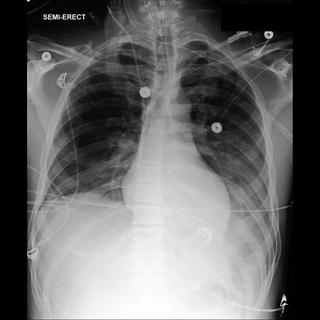

In [20]:
Image.open(final_image_text_df['image_fname'].sample().iloc[0])

#### Write the dataframe to the public folder (tejas)

In [22]:
with open('/scratch/tm3647/public/mimic_image_text_df.pkl', 'wb') as f:
    pickle.dump(final_image_text_df, f)

### Pytorch Dataset

In [10]:
class MIMICCXRDataset(torch.utils.data.Dataset):
    def __init__(self,  df_file:str , config=None, transforms=None, tokenizer=None):
        super(MIMICCXRDataset, self).__init__()
        
        self.config = config
        assert os.path.exists(df_file) and os.path.splitext(df_file)[1].lower()==".pkl", "Check file path exists and has the extension .pkl"
        
        with open(df_file, 'rb') as f:
            self.df = pickle.load(f)
        
        self.transforms = transforms
        self.tokenizer = tokenizer
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        record = self.df.iloc[idx]
        
        image = pyvips.Image.new_from_file(record['image_fname'], access="sequential")
        mem_img = image.write_to_memory()
        image = np.frombuffer(mem_img, dtype=np.uint8).reshape(image.height, image.width)
        #return image, record['image_fname']
        
        image = transforms.ToTensor()(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))
        
        findings = record['findings_tokenized_sentences']
        impressions = record['impressions_tokenized_sentences']
        
        find_impres = findings + impressions
        
        assert len(find_impres)!=0, f"Issue findings/impression of {record['patient_folder']}/{record['patient_id']}/{record['study_id']}"
        
        text = np.random.choice(find_impres)
        
        if self.transforms:
            image = self.transforms(image)
        
        if self.tokenizer:
            tokenized_input_data = self.tokenizer(text, max_length=128, padding="max_length", truncation=True, return_tensors="pt")
        
        return {'image':image, 'text': text, 'tokenized_data':tokenized_input_data}

#### Exps

In [36]:
mds = MIMICDataset('/scratch/tm3647/public/mimic_image_text_df.pkl')

In [37]:
for i in mds:
    break

In [34]:
transforms.ToTensor()(i['image'].squeeze().numpy())

torch.Size([3, 3056, 2544])

In [44]:
i['image'].shape

torch.Size([3, 3056, 2544])

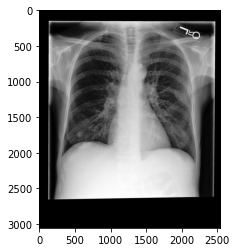

In [43]:
plt.imshow(transforms.ToPILImage()(i['image']))

#### Images write to disk

In [25]:
mds = MIMICCXRDataset('/scratch/tm3647/public/mimic_image_text_df.pkl')

In [55]:
for b in tqdm(mds):
    img = preprocess(Image.fromarray(b[0]))
    new_fname = os.path.splitext(b[1])[0]+'_resized.jpg'
    new_fname = new_fname.replace('/MIMIC_CXR_JPG/', '/vast/tm3647/physionet.org/files/mimic-cxr-jpg/2.0.0/')
    img.save(new_fname)

  0%|          | 310/360689 [00:33<10:46:39,  9.29it/s]


KeyboardInterrupt: 

### Pytorch DataModule

In [14]:
from transformers import AutoModel

In [22]:
from typing import Optional, Dict, Any

In [15]:
from pytorch_lightning import LightningDataModule 
from transformers import (
    AutoConfig,
    AutoTokenizer,
)
from torchvision import transforms
from tqdm.auto import tqdm
import time

In [32]:
class MIMICCXRDataModule(LightningDataModule):
    """Example of LightningDataModule for MNIST dataset.

    A DataModule implements 5 key methods:

        def prepare_data(self):
            # things to do on 1 GPU/TPU (not on every GPU/TPU in DDP)
            # download data, pre-process, split, save to disk, etc...
        def setup(self, stage):
            # things to do on every process in DDP
            # load data, set variables, etc...
        def train_dataloader(self):
            # return train dataloader
        def val_dataloader(self):
            # return validation dataloader
        def test_dataloader(self):
            # return test dataloader
        def teardown(self):
            # called on every process in DDP
            # clean up after fit or test

    This allows you to share a full dataset without explaining how to download,
    split, transform and process the data.

    Read the docs:
        https://pytorch-lightning.readthedocs.io/en/latest/data/datamodule.html
    """

    def __init__(
        self,
        mimic_cxr_dataset_file:str,
        batch_size: int = 64,
        num_workers: int = 0,
        pin_memory: bool = False,
        text_model_name:str = '',
        #cfg: dict = {},
    ):
        super(MIMICCXRDataModule,).__init__()

        # this line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        self.save_hyperparameters(logger=False)

        ## Image transformations
        self.transforms = transforms.Compose([
            transforms.RandomResizedCrop(224, ratio=[0.6, 1.0]),
            transforms.RandomAffine(degrees=[-20,20], translate=(0.1,0.1), scale=(0.95, 1.05)),
            transforms.ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4)),
            #transforms.GaussianBlur(G) ## Not implemented due to no info on kernel size in the paper
            #transforms.ToTensor(),
            transforms.Resize((224,224)),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
        
        ## Transforms
        self.tokenizer = AutoTokenizer.from_pretrained(text_model_name, use_fast=True)

        self.dataset: Optional[Dataset] = None

    def prepare_data(self):
        """Download data if needed.
        Do not use it to assign state (self.x = y).
        """
        pass

    def setup(self):
        """Load data

        This method is called by lightning with both `trainer.fit()` and `trainer.test()`, so be
        careful not to execute things like random split twice!
        """
        self.dataset = MIMICCXRDataset(self.hparams.mimic_cxr_dataset_file, transforms=self.transforms, tokenizer=self.tokenizer)

    def train_dataloader(self):
        return DataLoader(
            dataset=self.dataset,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=True,
        )

    def teardown(self, stage: Optional[str] = None):
        """Clean up after fit or test."""
        pass

    def state_dict(self):
        """Extra things to save to checkpoint."""
        return {}

    def load_state_dict(self, state_dict: Dict[str, Any]):
        """Things to do when loading checkpoint."""
        pass
    
    def collate_and_tokenize(self, batch):
        input_data = {}
        
        images = torch.cat(list(map(lambda x: torch.unsqueeze(x['image'], 0), batch)))
        texts = list(map(lambda x: x['text'], batch))
        
        input_data = self.tokenizer.batch_encode_plus(texts, max_length=128, padding=True, truncation=True, return_tensors="pt")
        
        keys = list(input_data.keys())
        input_data['tokenized_text'] = {}
        
        for k in list(keys):
            input_data['tokenized_text'][k]=input_data.pop(k)
        
        input_data['images'] = images
        input_data['texts'] = texts
        
        return input_data

#### Exps

In [39]:
dm = MIMICCXRDataModule('/scratch/tm3647/public/mimic_image_text_df.pkl', text_model_name='emilyalsentzer/Bio_ClinicalBERT', batch_size=32)

In [40]:
dm.setup()

In [ ]:
st_time = time.time()
for batch in tqdm(dm.train_dataloader()):
    images, texts = batch['image'], batch['text']
    print(time.time()-st_time)
    st_time = time.time()
    break

#### Flow janky stuff

In [ ]:
st_time = time.time()
for batch in tqdm(dm.train_dataloader()):
    images, texts = batch['image'], batch['text']
    print(time.time()-st_time)
    st_time = time.time()
    break

In [63]:
batch['tokenized_text']['input_ids'].shape

torch.Size([32, 38])

In [54]:
batch.keys()

dict_keys(['tokenized_text', 'images', 'texts'])

In [33]:
images.shape, len(texts)

(torch.Size([10, 3, 224, 224]), 10)

In [17]:
text_model_input = dm.tokenizer(batch['texts'][:3], return_tensors="pt", padding=True)
text_model_input

{'input_ids': tensor([[  101,  1103,  8682,  1132,  4303,  2330,  1114,  1185, 17811, 20994,
           117,   185,  1513, 12602,   174,  3101, 17268,  1137,   185,  1673,
          1818, 12858, 25632,   119,   102],
        [  101,  1103,  3621,  2660, 16418,  2050, 14196, 27316,  1110,  1439,
          2999,  6263,   119,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  1649,   117,  1107,  1103,  5806,  7300,  3545,   117,  7688,
          4060, 13541, 20673,  1156,  4664,  1138,  1106,  1129,  1737,   119,
           102,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [18]:
text_model = AutoModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [83]:
text_model_output = text_model(**text_model_input)

In [84]:
import torchvision
import torchsummary

In [30]:
image_model = torchvision.models.resnet50()
image_model = torch.nn.Sequential(*(list(image_model.children())[:-1]))
torchsummary.summary(image_model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [87]:
image_fv = image_model(batch['image'][0:3])
image_fv.shape

torch.Size([3, 2048, 1, 1])

In [42]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [89]:
sentence_embeddings = mean_pooling(text_model_output, text_model_input['attention_mask'])

In [90]:
proj_layer1 = torch.nn.Linear(768, 768)
proj_layer2 = torch.nn.Linear(768, 512)

In [91]:
text_proj_output = proj_layer2(proj_layer1(sentence_embeddings))

In [92]:
text_proj_output.shape

torch.Size([3, 512])

In [93]:
img_proj_layer1 = torch.nn.Linear(2048, 1024)
img_proj_layer2 = torch.nn.Linear(1024, 512)

In [96]:
img_proj_output = img_proj_layer2(img_proj_layer1(image_fv.squeeze()))

In [97]:
img_proj_output.shape

torch.Size([3, 512])

In [103]:
from torch.nn.functional import cosine_similarity, pairwise_distance

In [70]:
temperature = 0.1

In [102]:
cosine_similarity(img_proj_output, text_proj_output)

tensor([-0.0250, -0.0247, -0.0260], grad_fn=<SumBackward1>)

In [104]:
img_proj_output

tensor([[-0.0842,  0.1113,  0.1001,  ...,  0.4310,  0.5109,  0.7898],
        [-0.0466,  0.1326, -0.1249,  ...,  0.1610,  0.2572,  0.4917],
        [-0.1628,  0.0143,  0.0463,  ...,  0.4189,  0.5745,  0.8223]],
       grad_fn=<AddmmBackward0>)

In [106]:
import torchmetrics

In [111]:
img_text_sim = torchmetrics.functional.pairwise_cosine_similarity(img_proj_output, text_proj_output).detach()
img_text_sim

tensor([[-0.0250, -0.0479, -0.0319],
        [-0.0114, -0.0247, -0.0254],
        [-0.0219, -0.0463, -0.0260]])

In [ ]:
mean[(-0.0250 / sum(-0.0250, -0.0479, -0.0319)), -0.0247 / sum(-0.0114, -0.0247, -0.0254), ...]

In [112]:
text_img_sim = torchmetrics.functional.pairwise_cosine_similarity(text_proj_output, img_proj_output).detach()
text_img_sim

tensor([[-0.0250, -0.0114, -0.0219],
        [-0.0479, -0.0247, -0.0463],
        [-0.0319, -0.0254, -0.0260]])

In [116]:
a = torch.exp(img_text_sim)
a

tensor([[0.9753, 0.9533, 0.9686],
        [0.9886, 0.9756, 0.9749],
        [0.9783, 0.9548, 0.9744]])

In [131]:
-torch.log(0.9753 / sum(a[0]))

tensor(1.0888)

In [133]:
torch.diag(-torch.nn.functional.log_softmax(img_text_sim, 1))

tensor([1.0887, 1.1028, 1.0932])

In [135]:
lam = 0.75

In [138]:
## Final loss fn
torch.mean(lam*torch.diag(-torch.nn.functional.log_softmax(img_text_sim, 1)) + (1-lam)*torch.diag(-torch.nn.functional.log_softmax(text_img_sim, 1)))

tensor(1.0949)

In [75]:
vu_sim = cosine_similarity(img_proj_output, text_proj_output)
vu_sim

tensor([0.0929], grad_fn=<SumBackward1>)

In [71]:
torch.exp(vu_sim/temperature) / torch.sum(torch.exp())

tensor([2.5318], grad_fn=<ExpBackward0>)

### .....